In [23]:
import pathlib

import hydra
import torch
from captum.attr import IntegratedGradients
from torchvision.transforms import Compose
from captum.attr import visualization as viz

from tr_learn.data.dataset import PlateDataset
from tr_learn.model import PlateClassification
from tr_learn.utils import load_infer_info, remap_lighting_keys

In [2]:
config_path = pathlib.Path("exp", "cls_training", "config.yaml")

In [3]:
infer_info = load_infer_info(str(config_path))

In [4]:
config = infer_info.config

In [8]:
num_norm_transforms = len(config.transforms.normalize_transform)

In [10]:
last_norm_transforms = Compose(hydra.utils.instantiate(config.datamodule.predict_load_info.transforms[0]._args_[-num_norm_transforms:]))
config.datamodule.predict_load_info.transforms[0]._args_ = config.datamodule.predict_load_info.transforms[0]._args_[:-num_norm_transforms]

In [11]:
config.datamodule.predict_load_info.batch_size = 1
config.datamodule.predict_load_info.num_workers = 0

In [12]:
datamodule = hydra.utils.instantiate(config.datamodule)

d:\AnacondaEnvs\stepik-tl\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\AnacondaEnvs\stepik-tl\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue:

In [13]:
datamodule.setup("predict")

In [14]:
class_mapping = PlateDataset.get_label_mapping()

classes = [""] * len(class_mapping)

for label, index in class_mapping.items():
    classes[index] = label

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model: PlateClassification = hydra.utils.instantiate(config.model)
model.eval()
model.to(device);

In [17]:
model.load_state_dict(remap_lighting_keys(torch.load(infer_info.checkpoints[0].file_path, map_location=device)))

<All keys matched successfully>

In [18]:
test_loader = datamodule.predict_dataloader()

In [24]:
explain_method = IntegratedGradients(model)

In [29]:
def explain(explainer, batch, last_transform, device, classes):
    assert batch[0].shape[0] ==  1, "Expected one sample only"
    images = batch[0].to(device)
    input = last_transform(images)

    with torch.inference_mode():
        predicted_logits = model(input)
        scores = model.pos_prob(predicted_logits).cpu()
        predicted_label = model.predict_class(predicted_logits, 0.8).cpu()
        label = predicted_label.item()

    attr = explainer.attribute(input).cpu()

    return images.cpu(), [f"{classes[label]} Conf: {abs(1 - label - score.item()):.2%}" for index, score in zip(predicted_label, scores)], attr 

In [38]:
def show_pred(image, pred_label, attr_map):
    signs = {"original_image": "all",
         "heat_map": "all",
         "blended_heat_map": "all",
        "masked_image": "negative"
    }

    methods = list(signs.keys())

    _ = viz.visualize_image_attr_multiple(attr_map[0].permute(1, 2, 0).numpy(),
                                image[0].permute(1, 2, 0).numpy(),
                                methods=methods,
                                signs=list(signs.values()),
                                titles=[pred_label[0]] + methods[1:],
                                show_colorbar=True,
                                outlier_perc=1)

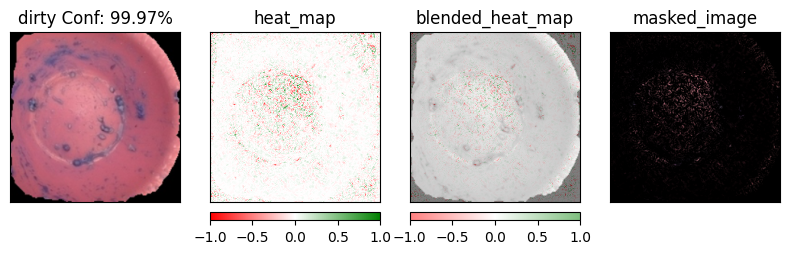

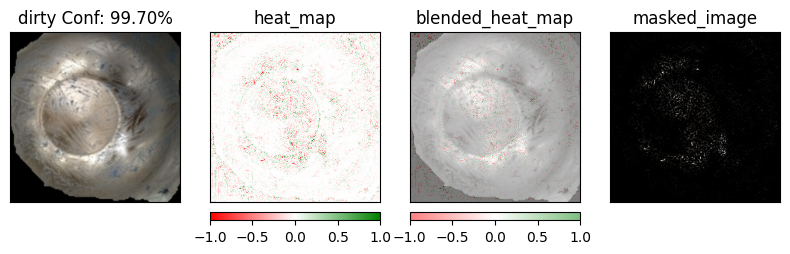

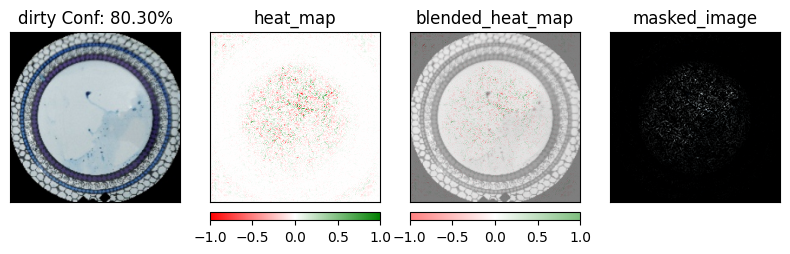

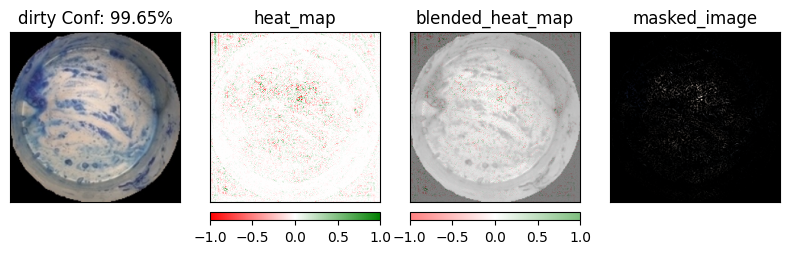

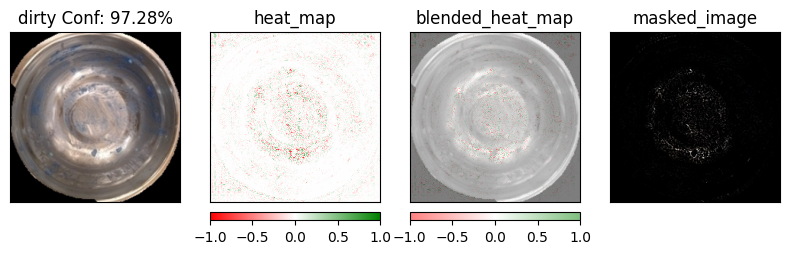

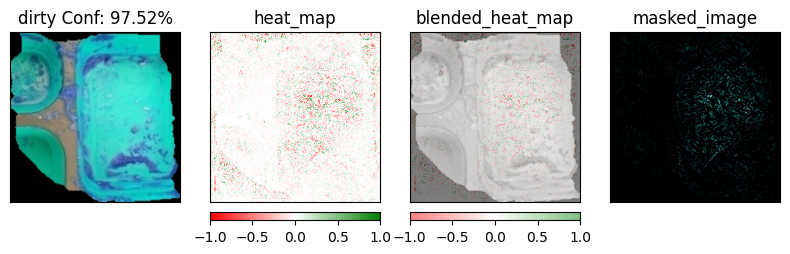

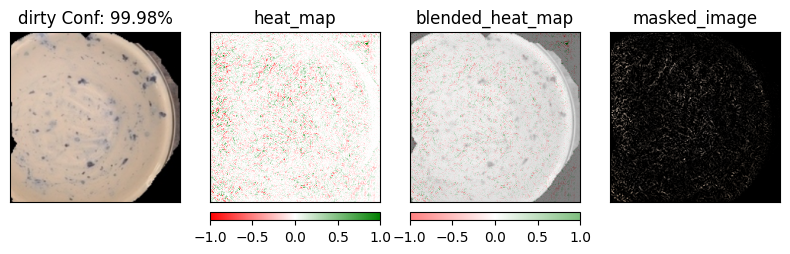

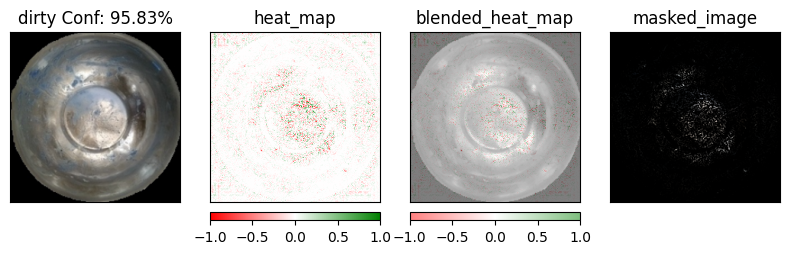

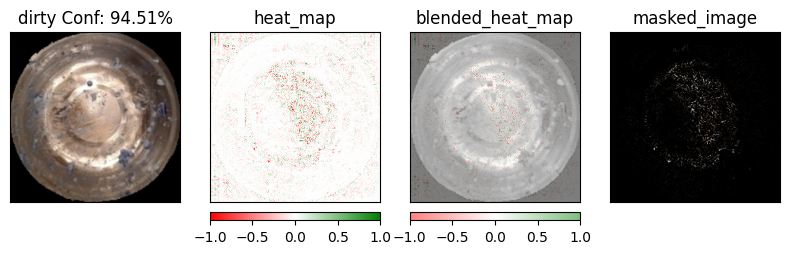

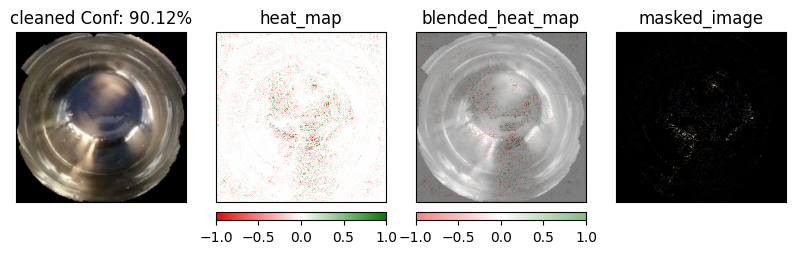

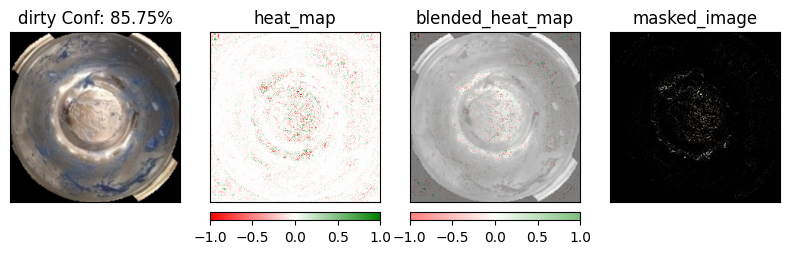

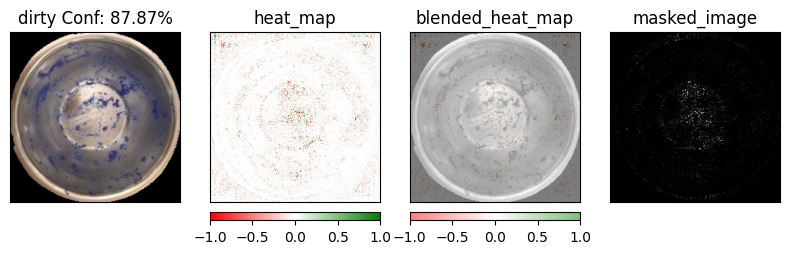

In [39]:
for i, batch in enumerate(test_loader):
    images, pred_labels, attr_map = explain(explain_method, batch, last_norm_transforms, device, classes) 

    show_pred(images, pred_labels, attr_map)
    
    if i > 10:
        break